In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
from sklearn.decomposition import PCA

# Load data and create datasets

In [2]:
datastore = h5py.File('trials6.h5', 'r')
batch_size = 100
n_comp = 40

raw_I = np.array(datastore["I"])
raw_c = np.array(datastore["c"])
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

pcaI = PCA(n_components=n_comp)
pcaI.fit(raw_I)
pcac = PCA(n_components=n_comp)
pcac.fit(raw_c)

data_I = torch.tensor(pcaI.transform(raw_I)).to(device)
data_c = torch.tensor(pcac.transform(raw_c)).to(device)

dataset = TensorDataset(data_I, data_c)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using mps device


# Define the model

In [3]:
class VarTransform(nn.Module):
    def __init__(self):
        super(VarTransform, self).__init__()

    def forward(self, x):
        # exp of the 4th input value; pass others unchanged
        x[:, 3] = torch.exp(x[:, 3])
        return x

class net(nn.Module):
    def __init__(self, n_components, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_components, 80),
            nn.ReLU(),
            nn.Linear(80, width),
            nn.ReLU(),
            nn.Linear(width, 80),
            nn.ReLU(),
            nn.Linear(80, n_components),
        )

    def forward(self, x):
        y = self.layers(x)
        return y
    
class net_thin(nn.Module):
    def __init__(self, n_components, width):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_components, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, n_components),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [4]:
model = net_thin(n_comp,200).to(device)
print(model)

net_thin(
  (layers): Sequential(
    (0): Linear(in_features=40, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=40, bias=True)
  )
)


# Training

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [6]:
learning_rate = 2e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 9.906743  [  100/32000]
loss: 3.454235  [10100/32000]
loss: 2.817136  [20100/32000]
loss: 1.997829  [30100/32000]
Test Error: Avg loss = 1.846327 

Epoch 2
-------------------------------
loss: 2.079950  [  100/32000]
loss: 0.980801  [10100/32000]
loss: 1.172357  [20100/32000]
loss: 0.258233  [30100/32000]
Test Error: Avg loss = 0.465782 

Epoch 3
-------------------------------
loss: 0.309879  [  100/32000]
loss: 0.153672  [10100/32000]
loss: 0.176092  [20100/32000]
loss: 0.101372  [30100/32000]
Test Error: Avg loss = 0.160967 

Epoch 4
-------------------------------
loss: 0.141055  [  100/32000]
loss: 0.072605  [10100/32000]
loss: 0.171786  [20100/32000]
loss: 0.114423  [30100/32000]
Test Error: Avg loss = 0.094961 

Epoch 5
-------------------------------
loss: 0.082289  [  100/32000]
loss: 0.074349  [10100/32000]
loss: 0.043657  [20100/32000]
loss: 0.062722  [30100/32000]
Test Error: Avg loss = 0.072867 

Epoch 6
----------------------

# Inspecting results

In [7]:
model(data_I[10:13])

tensor([[-2.2474e+01,  1.9404e+00, -4.7883e-01, -6.9327e-02,  1.5346e-01,
         -1.8914e-01,  1.6412e-01, -1.7274e-01,  8.6780e-02, -1.7958e-01,
          6.0164e-02,  8.2214e-02, -7.8770e-03, -8.1099e-02,  2.9002e-02,
         -3.0510e-02,  1.1379e-02, -3.5940e-02,  1.5677e-02,  5.4685e-03,
         -8.2567e-03, -1.8497e-02, -3.2754e-02,  3.0897e-02, -5.3805e-03,
          3.2111e-03, -6.2427e-03,  6.0405e-03,  7.1050e-03, -4.8672e-03,
          9.8464e-03,  9.3477e-03,  6.4630e-03, -1.5838e-02,  5.9664e-03,
         -1.1944e-02,  1.0495e-02,  9.7922e-03,  2.1544e-02, -5.0356e-03],
        [-1.3592e+01, -2.8080e+00,  2.2665e+00, -1.7644e+00,  1.3973e+00,
         -1.0246e+00,  6.9490e-01, -5.2277e-01,  3.1525e-01, -3.1818e-01,
          8.8454e-02,  1.3216e-01, -3.5670e-02, -6.6602e-02, -1.0212e-02,
         -2.7861e-03,  5.2888e-03, -1.3841e-02,  2.5897e-02,  1.3541e-03,
         -7.0283e-03, -1.4408e-02, -2.2840e-02,  1.7562e-02, -7.1788e-04,
         -1.6563e-03,  5.9039e-03,  4

In [8]:
data_c[10:13]

tensor([[-2.3195e+01,  2.0849e+00, -3.1785e-01,  5.2177e-02,  1.0395e-01,
         -7.3159e-02,  9.5243e-02, -7.3650e-02,  7.3238e-02, -5.8252e-02,
          5.2548e-02,  4.2110e-02, -3.7984e-02, -2.8706e-02,  2.5543e-02,
         -1.6209e-02,  1.2498e-02, -1.1070e-02, -4.2273e-03, -8.4655e-03,
          6.7207e-03, -8.5188e-03, -7.5793e-03,  4.5487e-03, -3.2559e-04,
          4.4747e-03, -4.3945e-03,  3.4527e-03,  7.3297e-04,  4.0403e-04,
          5.8584e-04,  6.2463e-04,  1.3813e-04,  7.1094e-04,  2.6375e-04,
         -1.4102e-03, -1.1289e-05, -9.3192e-04,  1.2624e-03,  1.6067e-04],
        [-1.4308e+01, -2.4845e+00,  2.3054e+00, -1.6995e+00,  1.3485e+00,
         -9.8763e-01,  7.2819e-01, -5.1755e-01,  3.7026e-01, -2.7222e-01,
          1.9547e-01,  1.4480e-01, -1.0394e-01, -7.0859e-02,  4.6763e-02,
         -2.6068e-02,  9.0804e-03, -6.9275e-03,  8.5999e-03, -1.3954e-02,
         -5.4482e-03, -1.4773e-02, -8.7819e-03,  3.7682e-03, -1.5234e-03,
          1.6469e-03,  6.3633e-04, -1

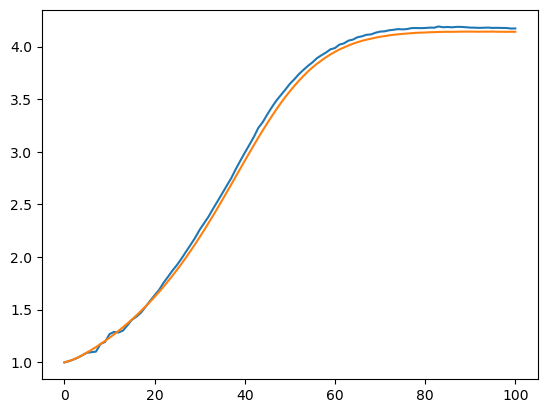

In [12]:
example = 11
with torch.no_grad():
    x, y = test_dataset[example]
    plt.plot(pcac.inverse_transform(model(x).cpu()))
    plt.plot(pcac.inverse_transform(y.cpu()))
plt.show()

# RMS error in time series

In [45]:
with torch.no_grad():
    test_osmo_pred = np.zeros((0, 101))
    test_osmo_actual = np.zeros((0, 101))
    for (x, y) in test_dataloader:
        test_osmo_pred = np.vstack((test_osmo_pred, pcac.inverse_transform(model(x).cpu())))
        test_osmo_actual = np.vstack((test_osmo_actual, pcac.inverse_transform(y.cpu())))
    train_osmo_pred = np.zeros((0, 101))
    train_osmo_actual = np.zeros((0, 101))
    for (x, y) in train_dataloader:
        train_osmo_pred = np.vstack((train_osmo_pred, pcac.inverse_transform(model(x).cpu())))
        train_osmo_actual = np.vstack((train_osmo_actual, pcac.inverse_transform(y.cpu())))

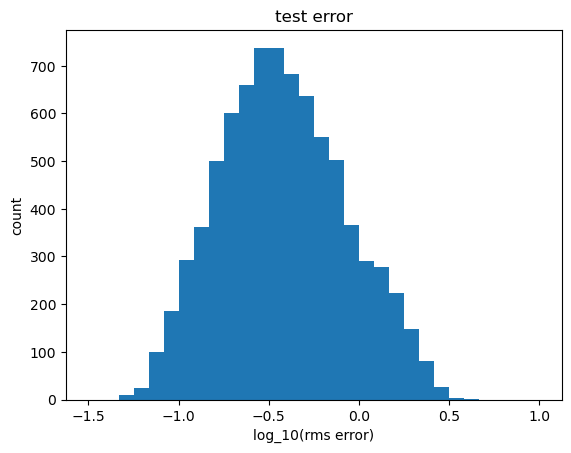

In [46]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, test_osmo_pred - test_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('test error')
plt.show()

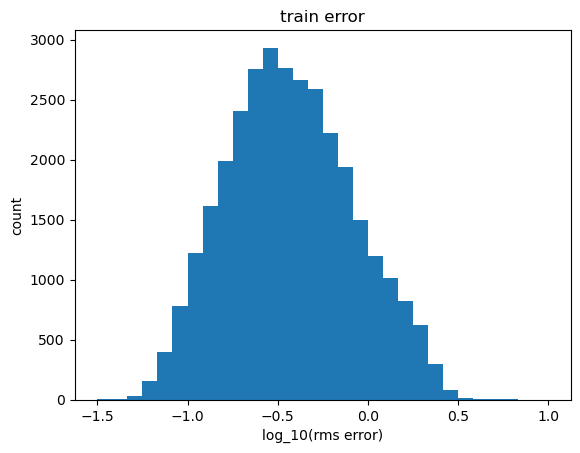

In [47]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, train_osmo_pred - train_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('train error')
plt.show()

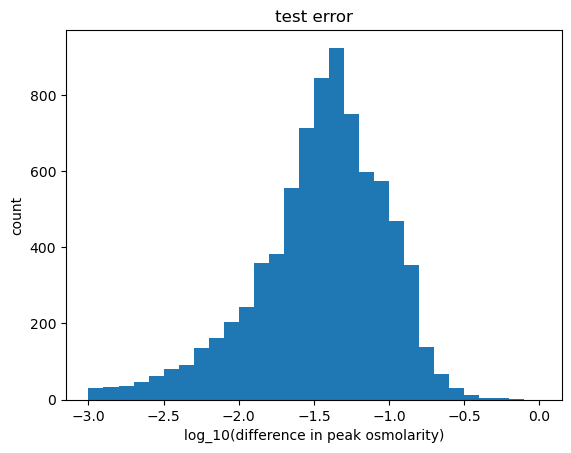

In [48]:
peakerror = np.max(test_osmo_pred, axis=1) - np.max(test_osmo_actual, axis=1)
plt.hist(np.log10(np.abs(peakerror)), bins=np.linspace(-3,0,31))
plt.xlabel('log_10(difference in peak osmolarity)')
plt.ylabel('count')
plt.title('test error')
plt.show()

In [56]:
#torch.save(model.state_dict(), 'model_osm_pca_size_40x200')